In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import time
import pickle
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from package.plots import diagnostic_plot, plot, lens_plot
from package.helpers.lens import Lens
from package.helpers import pyhalo

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [3]:
data_dir = os.path.join('/data','bwedig', 'roman-population', 'data')
figure_dir = os.path.join(repo_path, 'figures')

In [4]:
csv_path = os.path.join(data_dir, 'dictparaggln_Area00000010.csv')
df = pd.read_csv(csv_path)

In [5]:
limit = 16

df.head(limit)

,velodisp,massstel,angleins,redssour,redslens,xposlens,yposlens,xpossour,ypossour,numbimag,magnsour,maxmdistimag,magtlensF106,magtsourF106,magtsourMagnifiedF106
0,251.025397,0.036141,1.084403,2.310156,0.616690,-0.141015,0.043382,-1.106556,0.981286,1.0,1.369664,NaN,21.885183,21.923449,21.581914
1,251.025397,0.036141,0.617908,1.048704,0.616690,-0.063282,0.000795,0.290395,1.652574,1.0,1.480503,NaN,21.885183,23.000643,22.574621
2,251.025397,0.036141,0.558357,0.981603,0.616690,0.085376,-0.123559,0.574170,1.027743,1.0,1.840321,NaN,21.885183,23.436977,22.774743
3,275.859863,0.189665,0.575309,1.277251,0.840802,-0.122405,-0.099575,0.229196,-0.471078,2.0,2.217466,1.233549,21.062455,23.321226,22.456583
4,275.859863,0.189665,1.010629,2.136921,0.840802,-0.014995,0.037117,-0.674593,0.819483,2.0,2.172031,2.122993,21.062455,23.948160,23.105994
5,275.859863,0.189665,0.498959,1.194140,0.840802,-0.023646,0.017482,1.256379,1.366837,1.0,1.358797,NaN,21.062455,23.570487,23.237601
6,275.859863,0.189665,0.951266,1.955572,0.840802,-0.063334,0.173066,-0.855267,-0.712657,1.0,1.522384,NaN,21.062455,23.193224,22.736914
7,275.859863,0.189665,0.706240,1.451394,0.840802,-0.014367,0.029347,1.423275,0.001612,1.0,1.319173,NaN,21.062455,23.611526,23.310772
8,258.235759,0.076367,1.146890,3.127759,0.737675,-0.118176,0.111632,-0.082367,-0.716826,2.0,1.761327,2.209537,21.592352,23.556204,22.941604
9,258.235759,0.076367,1.033841,2.353918,0.737675,-0.129202,0.013501,-0.004000,0.996112,2.0,1.876932,1.999783,21.592352,23.343351,22.659729


In [6]:
df.columns

Index(['velodisp', 'massstel', 'angleins', 'redssour', 'redslens', 'xposlens',
       'yposlens', 'xpossour', 'ypossour', 'numbimag', 'magnsour',
       'maxmdistimag', 'magtlensF106', 'magtsourF106',
       'magtsourMagnifiedF106'],
      dtype='object')

In [7]:
lens_list = []

for i, row in tqdm(df.iterrows(), total=limit):
    if i == limit:
        break
    lens = Lens(z_lens=row['redslens'], 
                z_source=row['redssour'], 
                sigma_v=row['velodisp'], 
                lens_x=row['xposlens'], 
                lens_y=row['yposlens'], 
                source_x=row['xpossour'], 
                source_y=row['ypossour'], 
                mag_lens=row['magtlensF106'], 
                mag_source=row['magtsourF106'])
    
    # add CDM subhalos
    try:
        lens.add_subhalos(*pyhalo.generate_CDM_halos(lens.z_lens, lens.z_source))
    except:
        print(lens.z_lens, lens.z_source)
        limit += 1
        continue
    
    lens_list.append(lens)

  0%|          | 0/16 [00:00<?, ?it/s]

 94%|█████████▍| 15/16 [04:39<00:08,  8.35s/it]

1.5732122562553963 3.639509408543994
1.5732122562553963 2.7956673961572207
1.5732122562553963 2.060668381768476
1.5732122562553963 3.808460552765313
1.5732122562553963 2.8522048055210343


21it [07:48, 22.31s/it]                        


100%|██████████| 16/16 [08:44<00:00, 32.78s/it]


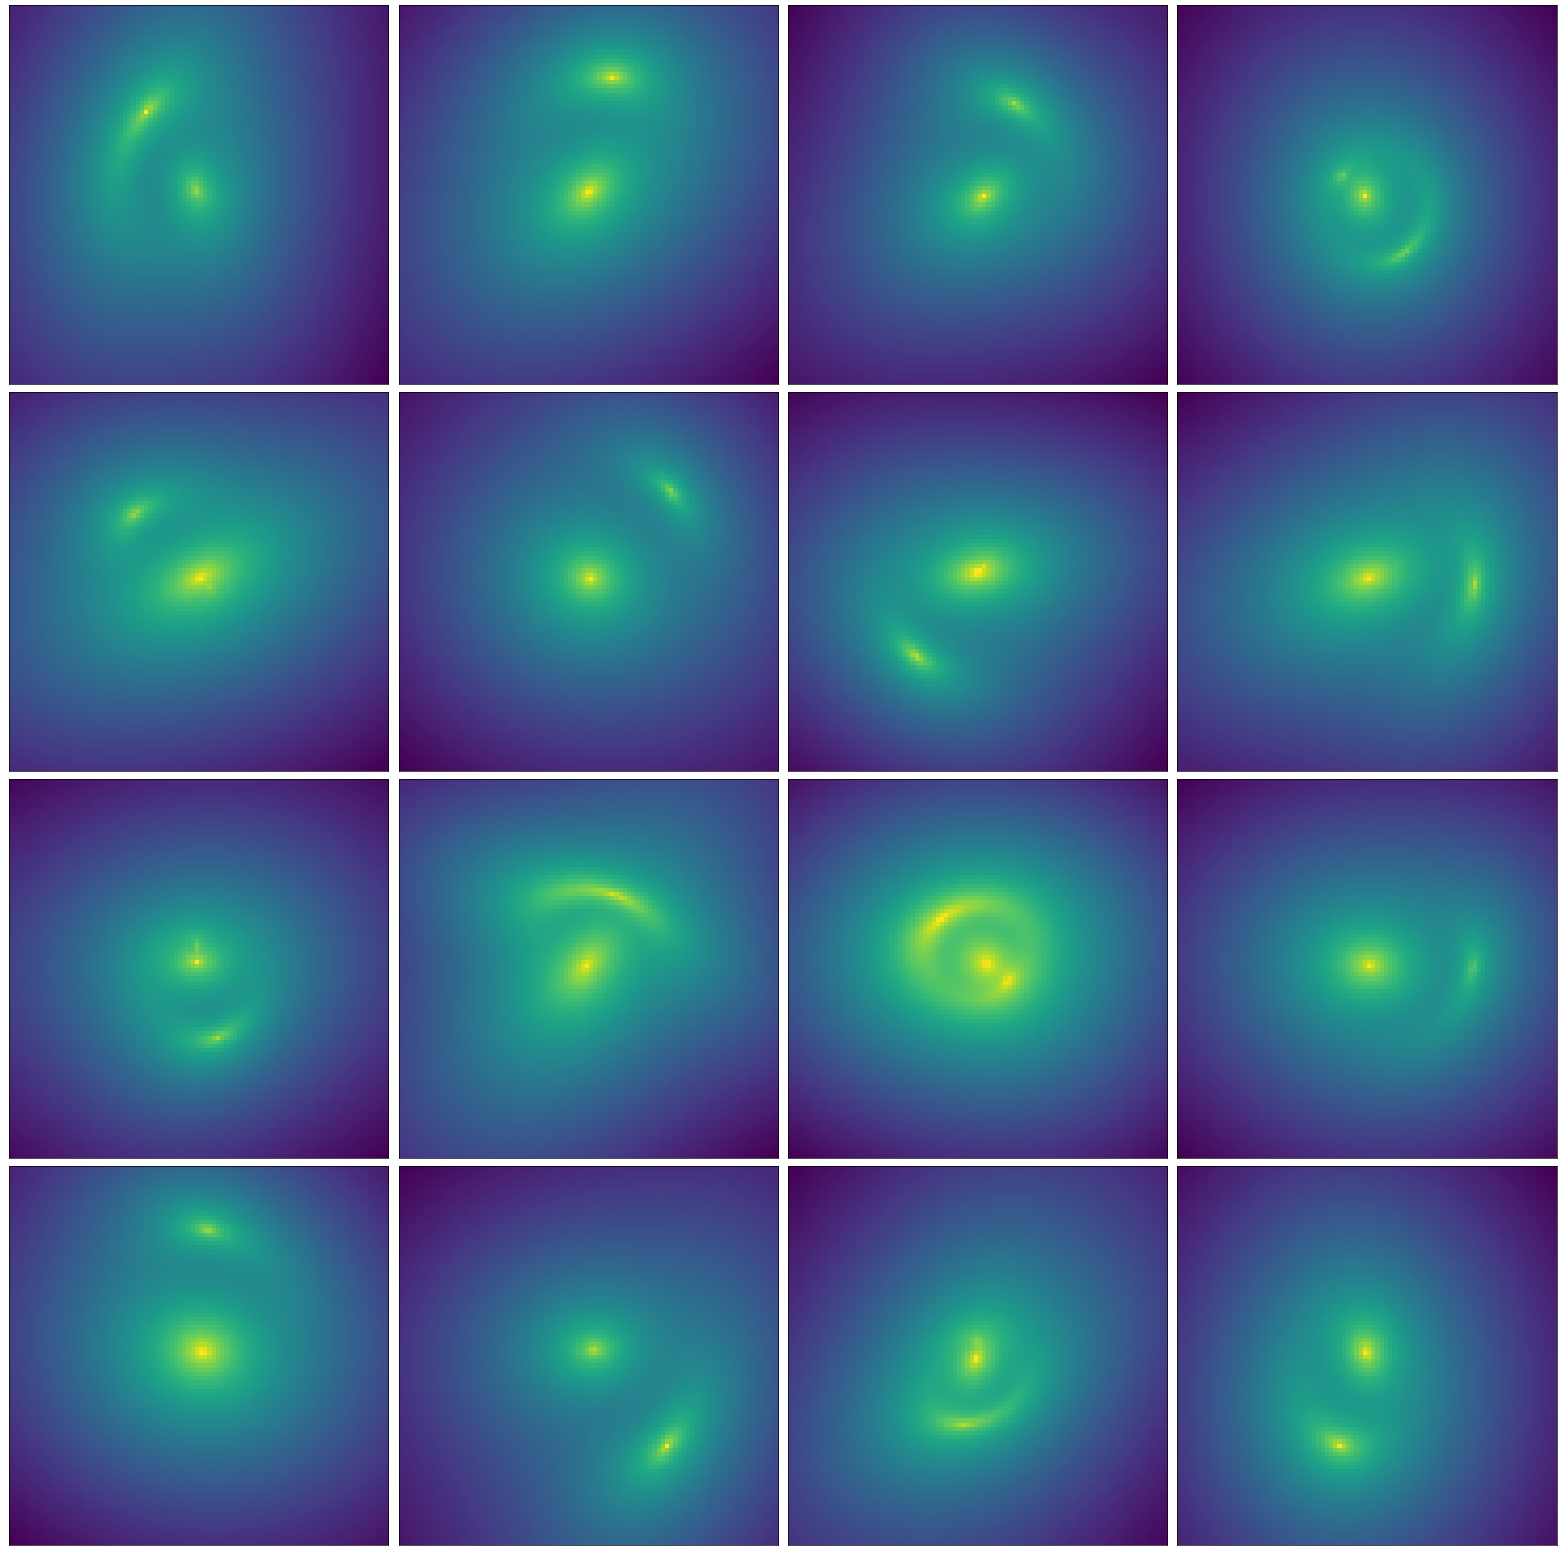

In [8]:
side = 4
f, ax = plt.subplots(nrows=side, ncols=side, figsize=(20, 20), gridspec_kw={'hspace': 0.02,'wspace':0.02})

for i, lens in tqdm(enumerate(lens_list), total=len(lens_list)):
    model = lens.get_array(num_pix=90, side=10.)
    ax[i//side,i%side].imshow(np.log10(model), cmap='viridis')
    ax[i//side,i%side].get_xaxis().set_visible(False)
    ax[i//side,i%side].get_yaxis().set_visible(False)
    
plt.savefig(os.path.join(figure_dir, 'mosaic_models.png'))
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]


TypeError: hessian() got an unexpected keyword argument 'sigma_v'

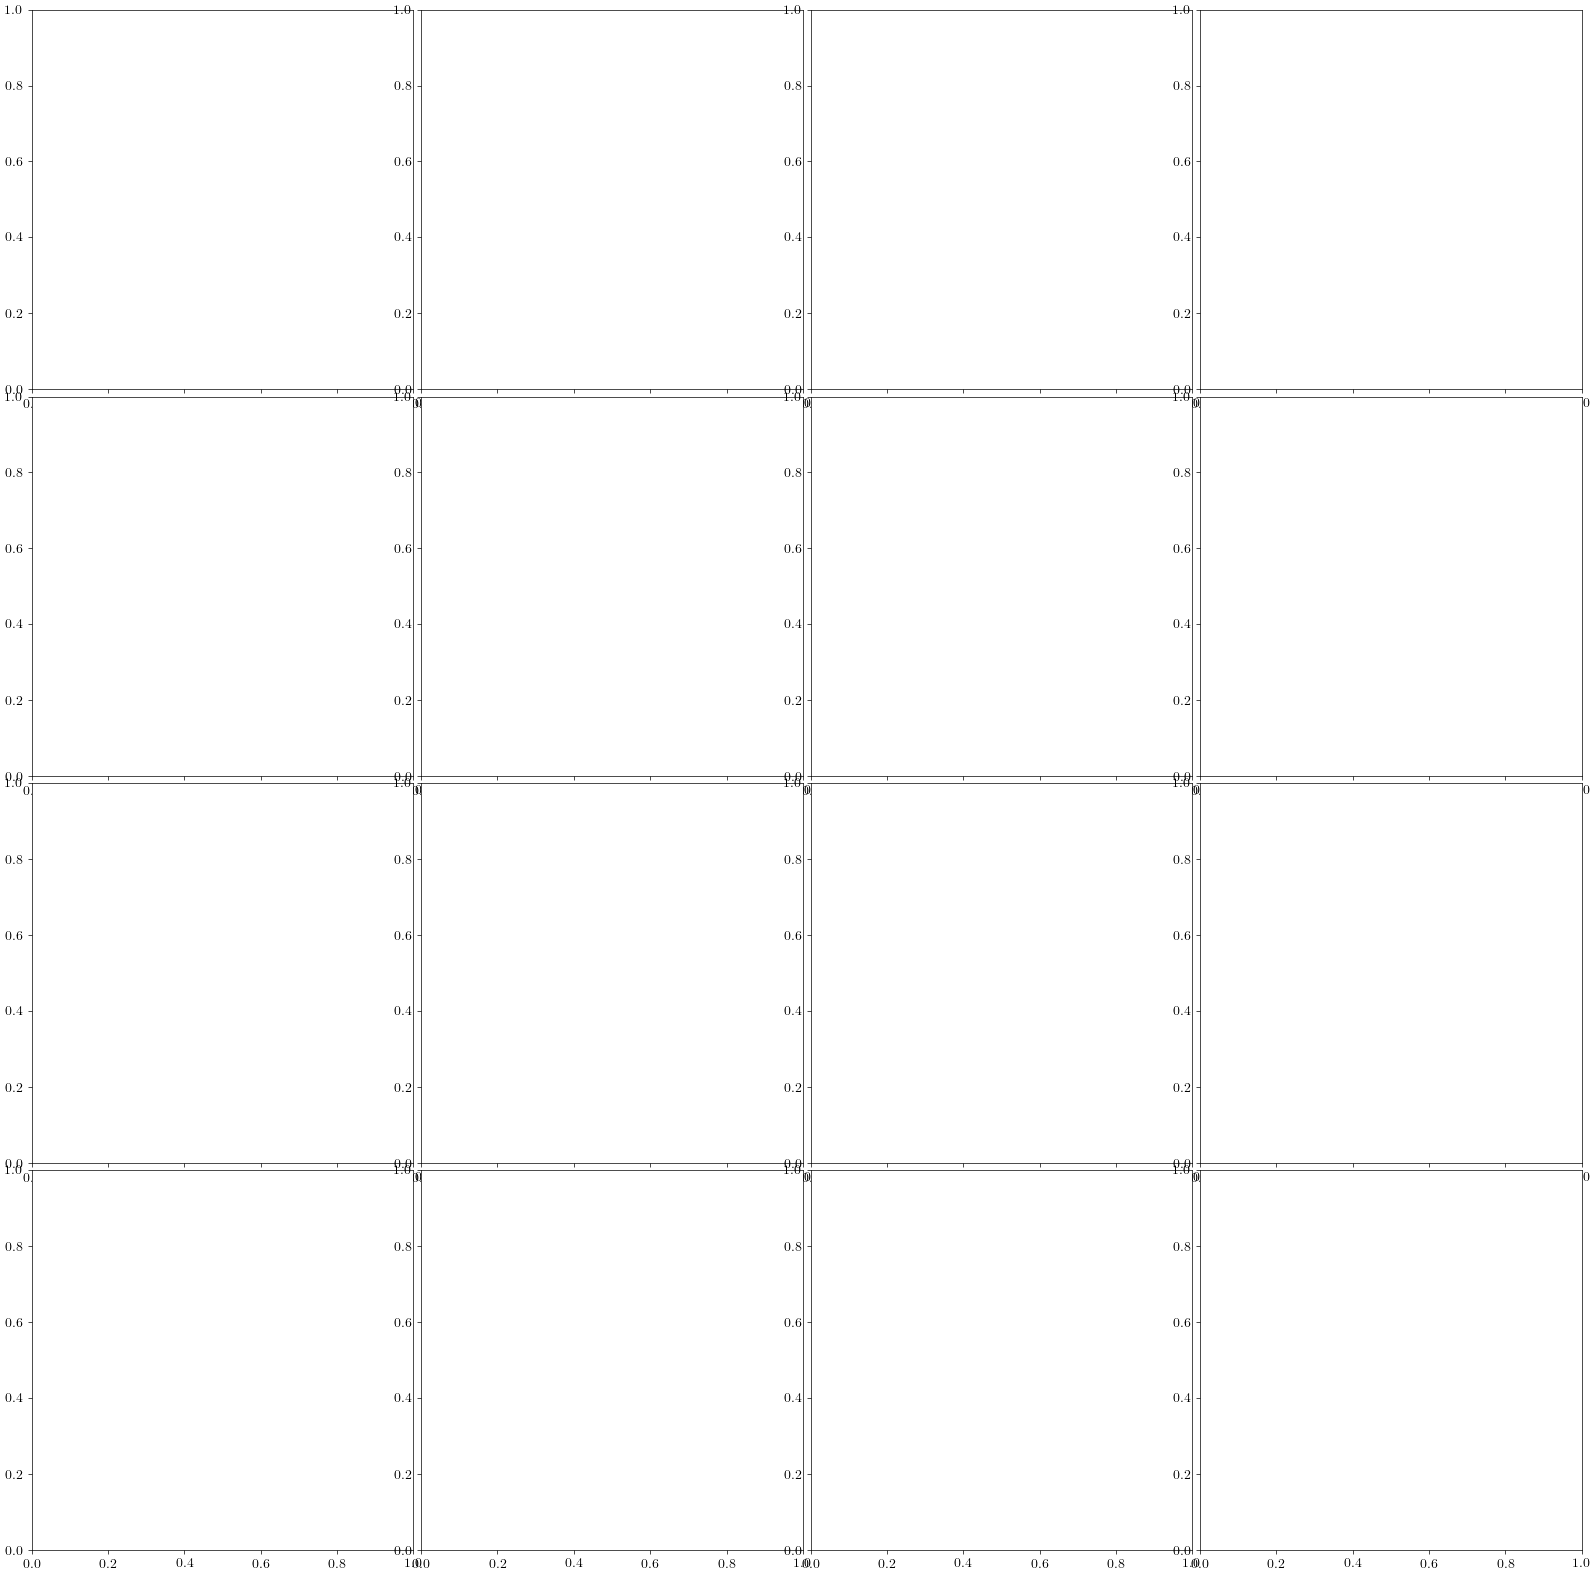

In [9]:
side = 4
f, ax = plt.subplots(nrows=side, ncols=side, figsize=(20, 20), gridspec_kw={'hspace': 0.02,'wspace':0.02})

for i, lens in tqdm(enumerate(lens_list), total=len(lens_list)):
    lens.update_classes()
    ax[i//side,i%side] = lens_plot.plot_projected_mass(lens)
    ax[i//side,i%side].get_xaxis().set_visible(False)
    ax[i//side,i%side].get_yaxis().set_visible(False)
    
plt.savefig(os.path.join(figure_dir, 'skypy_output_test_mass_proj.png'))
plt.show()